In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

%load_ext autoreload
%autoreload 2

# Simulated Preference Dataset Generator
- original code
- subgroups

In [107]:
########### hyperparameters for the dataset ################
feature_dim = 20
metric_rank = 1
num_items = 100
num_users = 10
num_pairs_per_user = 300
noise_type = 'logistic'
noise_beta = 1
# noise_type = 'none'
# noise_beta = 0
num_groups = 3

In [96]:
import scipy.stats as st
import numpy as np
from sklearn.model_selection import train_test_split
import scipy.io as sio
import utils


'''
Desc: Generates normally distributed data along with ground-truth metric and user points (Refer to the original code)

Inputs:
    feature_dim: feature dimensions
    metric_rank: metric rank
    num_items: number of items
    num_users: number of users
    num_pairs_per_user: number of measurements per user
    noise type: type of noise in measurement model, from {'none', 'logistic'}
    noise_beta: noise level
    num_groups: number of subgroups
'''

assert metric_rank <= feature_dim, 'metric rank must be equal to or smaller then feature dim'

# generate ground-truth metric
if metric_rank < feature_dim:
    # low-dimensional orthogonal matrix
    L = st.ortho_group.rvs(dim=feature_dim)
    L = L[:,:metric_rank]
    M = (feature_dim / np.sqrt(metric_rank)) * L @ L.T  # keep the frob_norm = feature_dim
elif metric_rank == feature_dim:
    # arbitrary PSD metric, normalized to have Frobenius norm of d
    L = np.random.multivariate_normal(np.zeros(feature_dim), np.eye(feature_dim), feature_dim)
    M = L @ L.T
    M = M * (feature_dim / np.linalg.norm(M, 'fro'))

# generate user points (methods depend on the size of the num_groups)
if num_groups == 1:
    # original code
    U = np.random.multivariate_normal(np.zeros(feature_dim), (1/feature_dim)*np.eye(feature_dim), num_users).T
    # pseudo user points
    V = -2*M @ U
    # generate items and comparisons
    Xdata = np.random.multivariate_normal(np.zeros(feature_dim), (1/feature_dim)*np.eye(feature_dim), num_items).T
    S = list(zip(list(np.repeat(list(range(num_users)), num_pairs_per_user)),
                       [tuple(np.random.choice(num_items, 2, replace=False)) for _ in range(num_pairs_per_user*num_users)]))
    Y, Y_noiseless, Y_unquant = utils.one_bit_pairs(Xdata, S, M, V, noise_type, noise_beta)
elif num_groups > 1:
    # only need to create several ideal points (num_groups)
    U_subgroups = np.random.multivariate_normal(np.zeros(feature_dim), (1/feature_dim)*np.eye(feature_dim), num_groups).T
    # Then we need to simulate different users, each user's point is a weight-average of the ideal points
    alpha = np.random.rand(num_users, num_groups)
    alpha = alpha / alpha.sum(axis=1).reshape(-1,1)
    U = U_subgroups @ alpha.T
    # pseudo user points
    V = -2*M @ U
    # generate items and comparisons
    Xdata = np.random.multivariate_normal(np.zeros(feature_dim), (1/feature_dim)*np.eye(feature_dim), num_items).T
    S = list(zip(list(np.repeat(list(range(num_users)), num_pairs_per_user)),
                       [tuple(np.random.choice(num_items, 2, replace=False)) for _ in range(num_pairs_per_user*num_users)]))
    Y, Y_noiseless, Y_unquant = utils.one_bit_pairs(Xdata, S, M, V, noise_type, noise_beta)





# group_dataset test

In [2]:
from group_dataset import Dataset
from metric_check import train_main

########### hyperparameters for the dataset ################
feature_dim = 10
metric_rank = 1
num_items = 100
num_users = 10
num_pairs_per_user = 1000
noise_type = 'logistic'
noise_beta = 1
num_groups = 3

In [3]:
normal_dataset = Dataset(dataset_type='Normal',
                         d=feature_dim,
                         r=metric_rank,
                         n=num_items,
                         N=num_users,
                         m=num_pairs_per_user,
                         noise_type=noise_type,
                         noise_beta=noise_beta,
                         num_groups=num_groups)

In [4]:
########### initialize the dataloders ################
normal_data = normal_dataset.getAllData()
items, observations, true_y, true_M, true_u = normal_data['X'], normal_data['S'], normal_data['Y'], normal_data['M'], normal_data['U']
true_y_noiseless = normal_dataset.Y_noiseless

In [5]:
args = {
        'feature_dim': 10,
        'metric_rank': 1,
        'num_items': 100,
        'num_users': 10,
        'num_pairs_per_user': 300,
}

train_stats, learner = train_main(args, normal_dataset, relative_error_ind=False)

100%|██████████| 2000/2000 [01:32<00:00, 21.51it/s, test_accu=0.804]


In [3]:
from group_dataset import Dataset
from metric_check import train_main
from tqdm import tqdm

res_list = []

for i in tqdm(range(1,10)):
    ########### hyperparameters for the dataset ################
    feature_dim = 10
    metric_rank = 10
    num_items = 100
    num_users = 100
    num_pairs_per_user = 1000
    noise_type = 'logistic'
    noise_beta = 1
    num_groups = i

    normal_dataset = Dataset(dataset_type='Normal',
                            d=feature_dim,
                            r=metric_rank,
                            n=num_items,
                            N=num_users,
                            m=num_pairs_per_user,
                            noise_type=noise_type,
                            noise_beta=noise_beta,
                            num_groups=num_groups)

    ########### initialize the dataloders ################
    normal_data = normal_dataset.getAllData()
    items, observations, true_y, true_M, true_u = normal_data['X'], normal_data['S'], normal_data['Y'], normal_data['M'], normal_data['U']
    true_y_noiseless = normal_dataset.Y_noiseless

    args = {
            'feature_dim': feature_dim,
            'metric_rank': metric_rank,
            'num_items': num_items,
            'num_users': num_users,
            'num_pairs_per_user': 300,
    }

    train_stats, learner = train_main(args, normal_dataset, relative_error_ind=False)

    res_list.append((train_stats, learner))

  0%|          | 0/9 [00:00<?, ?it/s]

 11%|█         | 1/9 [16:05<2:08:42, 965.34s/it]

In [ ]:
torch.save(res_list,'subgroups_res_list.pt')

In [2]:
res_list = torch.load('subgroups_res_list.pt')

In [6]:
num_subgroups_list = list(range(1,11))
test_accu_list = []
for res in res_list:
    test_accu_list.append(res[0]['test_accu_record'][-1])

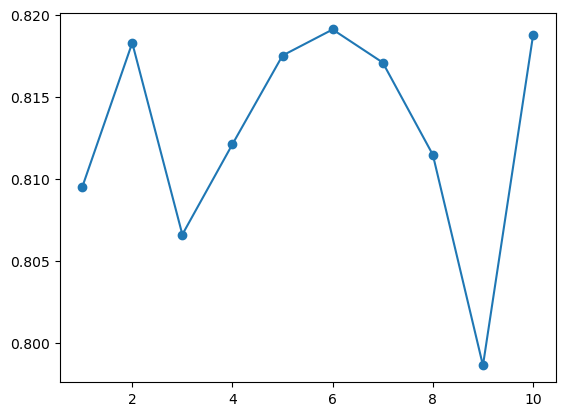

In [8]:
import matplotlib.pyplot as plt
plt.plot(num_subgroups_list,test_accu_list,'-o')

# MetricPreferenceLearner (subgroups version)

In [10]:
# original version

import torch
import torch.nn as nn
import torch.nn.functional as F

class MetricPrefLearner(nn.Module):
    
    def __init__(self, dim_feature, num_users, items):
        '''
        items shape: np.array (dim_feature, num_items)
        '''
        super().__init__()
        self.dim_feature = dim_feature
        self.num_users = num_users
        self.items = items
        self.us = nn.Parameter(torch.randn((self.dim_feature, self.num_users)))

    def assignModel(self, init_model):
        '''
        Use whatever model you like
        One Condition must be satisfied: input_dim == output_dim == dim_feature
        '''
        self.model = init_model

    def forward(self, x):
        '''
        x shape: (user_id, (item_i, item_j))
        '''
        user_ids, x_is, x_js = x[0], x[1][0], x[1][1]
        x_is, x_js = torch.Tensor(self.items[:,x_is]), torch.Tensor(self.items[:,x_js])
        us_k_track =self.us[:,user_ids]
        x_is_minus_us = (x_is - us_k_track).T
        x_js_minus_us = (x_js - us_k_track).T
        ele_1 = self.model(x_is_minus_us)
        ele_2 = self.model(x_js_minus_us)
        delta = torch.sum(ele_1 * ele_1, dim=1) - torch.sum(ele_2 * ele_2, dim=1)
        return delta

In [ ]:
# updated version: use subgroups + softmax weights

import torch
import torch.nn as nn
import torch.nn.functional as F

class MetricPrefLearner(nn.Module):
    
    def __init__(self, dim_feature, num_users, items, num_groups=None):
        '''
        items shape: np.array (dim_feature, num_items)
        '''
        super().__init__()
        self.dim_feature = dim_feature
        self.num_users = num_users
        self.items = items
        self.us = nn.Parameter(torch.randn((self.dim_feature, self.num_users)))
        self.num_groups = num_groups

    def assignModel(self, init_model):
        '''
        Use whatever model you like
        One Condition must be satisfied: input_dim == output_dim == dim_feature
        '''
        self.model = init_model

    def forward(self, x):
        '''
        x shape: (user_id, (item_i, item_j))
        '''
        user_ids, x_is, x_js = x[0], x[1][0], x[1][1]
        x_is, x_js = torch.Tensor(self.items[:,x_is]), torch.Tensor(self.items[:,x_js])
        us_k_track =self.us[:,user_ids]
        x_is_minus_us = (x_is - us_k_track).T
        x_js_minus_us = (x_js - us_k_track).T
        ele_1 = self.model(x_is_minus_us)
        ele_2 = self.model(x_js_minus_us)
        delta = torch.sum(ele_1 * ele_1, dim=1) - torch.sum(ele_2 * ele_2, dim=1)
        return delta

# Just for verification

In [132]:
# true prediction (just for verification) original just one subgroup version
delta_s = []
pred_ys = []
for obs in S:
    user_id, comparison_pair = obs
    x_i, x_j = comparison_pair
    delta = (Xdata[:,x_i]-U[:,user_id]).T @ M @ (Xdata[:,x_i]-U[:,user_id]) - (Xdata[:,x_j]-U[:,user_id]).T @ M @ (Xdata[:,x_j]-U[:,user_id])
    delta_s.append(delta)
    if delta > 0:
        pred_y = 1
    else:
        pred_y = -1
    pred_ys.append(pred_y)
assert np.all(pred_ys == Y_noiseless), "doesn't match!"

In [137]:
# true prediction (just for verification) original version
delta_s = []
pred_ys = []
for obs in observations:
    user_id, comparison_pair = obs
    x_i, x_j = comparison_pair
    delta = (items[:,x_i]-true_u[:,user_id]).T @ true_M @ (items[:,x_i]-true_u[:,user_id]) - (items[:,x_j]-true_u[:,user_id]).T @ true_M @ (items[:,x_j]-true_u[:,user_id])
    delta_s.append(delta)
    if delta > 0:
        pred_y = 1
    else:
        pred_y = -1
    pred_ys.append(pred_y)
assert np.all(pred_ys == true_y_noiseless)